# Fault Diagnosis using Deep Learning
In this post we will apply deep learning to CWRU data set. We will apply a standard convolutional neural network (CNN) architecture to raw vibration data. The data used in this experiment can be downloaded from the link mentioned below.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

2.0.0


## Data
We have used CWRU data for this demonstration. It is a standard database used in condition monitoring applications. We have used the drive end data that are sampled at 48 kHz sampling frequency when load of 1 hp is applied on the shaft. Normal data collected with 1 hp load have also been used. There are a total of 10 classes. The classes are

* C1  : Ball defect (0.007 inch, load: 1 hp)
* C2  : Ball defect (0.014 inch, load: 1 hp)
* C3  : Ball defect (0.021 inch, load: 1 hp)
* C4  : Inner race fault (0.007 inch, load: 1 hp)
* C5  : Inner race fault (0.014 inch, load: 1 hp)
* C6  : Inner race fault (0.021 inch, load: 1 hp)
* C7  : Normal (load: 1 hp)
* C8  : Outer race fault (0.007 inch, load: 1 hp, data collected from 6 O'clock position)
* C9  : Outer race fault (0.014 inch, load: 1 hp, 6 O'clock)
* C10 : Outer race fault (0.021 inch, load: 1 hp, 6 O'clock)

From each category data are collected in segments of length 1024 and resized to a 2-D matrix of size (32 by 32). There is no overlap between segments. For each category 460 such segments are taken. Total size of the data thus becomes (4600, 32, 32). Out of this 1300 segments are randomly chosen as test data and rest are used for training. Readers can directly download the data from the link mentioned below.

[Download the data from here](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/data/CWRU_48k_load_1_CNN_data.npz). Another convenient way is to [download the whole repository](https://codeload.github.com/biswajitsahoo1111/cbm_codes_open/legacy.zip/master) and run the downloaded notebooks.

(**Note**: In the original data of CWRU, inner race fault of 0.014 inch with sampling frequency of 48 kHz and load of 1 hp is stored as a file named '175.mat'. Inside this file there are following sub fields:
            
            X217: [489125×2 double]
    X217_DE_time: [489125×1 double]
    X175_DE_time: [381890×1 double]
    X175_FE_time: [381890×1 double]
         X175RPM: 1772
         
The file 'X175_DE_time' has less data points. From it we can't extract 460 segments of length 1024 without overlap. So we have used 'X217_DE_time' instead as our 0.014 inch outer race fault data. From this file 460 segments can be extracted. In the 'numpy' file this data is used for 'IR_014' category. For all other categories respective drive end data are used.)

In [3]:
# Run the notebook after cloning the repo
file = np.load('./data/CWRU_48k_load_1_CNN_data.npz') # Give path to downloaded file in your system
print(file.files)

['data', 'labels']


In [4]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [5]:
print(data[0])
print(labels)

[[-0.041097  -0.046104  -0.028372  ... -0.042975  -0.11453   -0.17711  ]
 [-0.23052   -0.26348   -0.26077   ... -0.023782  -0.11787   -0.18775  ]
 [-0.20882   -0.19297   -0.15208   ... -0.017524  -0.063628  -0.11411  ]
 ...
 [ 0.02253   -0.049859  -0.11098   ... -0.036508  -0.03317   -0.02858  ]
 [-0.0031292  0.030249   0.063419  ... -0.035882  -0.010014   0.030875 ]
 [ 0.06029    0.072598   0.076145  ...  0.13602    0.10139    0.066548 ]]
['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']


In [6]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


In [7]:
labels = pd.Categorical(labels, categories = category_labels).codes

## Train test split

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 1300, random_state = 829, 
                                                                    stratify = labels)

In [9]:
# reshape data
train_data = train_data.reshape(3300,32,32,1)
test_data = test_data.reshape(1300,32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(3300, 32, 32, 1) (3300, 10) (1300, 32, 32, 1) (1300, 10)


## Model
We have used LeNet-5 model for classification. Details of model architecture is shown below. Any other architecture can also be used. 

In [10]:
# LeNet-5
LeNet_5 = Sequential([
    layers.Conv2D(6,5,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(16,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(120,activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])
LeNet_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

Deep learning model weights are initialized randomly. Due to inherent non-deterministic nature of processing, we will get different answers if we run the same model twice. The answers will also vary from computer to computer depending on architecture. The answers will also vary depending on software version. In our experiment we have used `Tensorflow-2.0.0`. So we have run the model 10 times and final result is the average of all. In the process we have also saved the best model. 

In [11]:
res = np.empty(10)
res[:] = np.nan
for i in range(10):
    model = Sequential([
    layers.Conv2D(6,5,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(16,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(120,activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                  metrics= ['accuracy'])
    history = model.fit(train_data, train_labels, epochs = 50, batch_size = 128, verbose = 0)    # Verbosity is set to zero
    res[i] = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)[1]            # Verbosity is set to zero
    print('Loop iteration %d, Accuracy: %4.4f' % (i+1, res[i]))
    if res[i]>=np.max(res[:(i+1)]):
        best_model = model

Loop iteration 1, Accuracy: 0.9631
Loop iteration 2, Accuracy: 0.9577
Loop iteration 3, Accuracy: 0.9623
Loop iteration 4, Accuracy: 0.9700
Loop iteration 5, Accuracy: 0.9515
Loop iteration 6, Accuracy: 0.9523
Loop iteration 7, Accuracy: 0.9700
Loop iteration 8, Accuracy: 0.9708
Loop iteration 9, Accuracy: 0.9654
Loop iteration 10, Accuracy: 0.9523


In [12]:
print('Average accuracy:%4.4f'%(np.mean(res))) # After running the model 10 times
print('Standard deviation: %4.4f' % (np.std(res)))

Average accuracy:0.9615
Standard deviation: 0.0073


## Saving the best model

It is very much likely that readers obtain different accuracy for each epoch and ultimately obtain a different final accuracy. And for complex models with more parameters, it might not be possible for all readers to train such a model from scratch using their personal computer (Some state of the art deep learning models developed by big tech companies take weeks or even months to train over multiple GPUs. It is not possible for an individual (including this author) to train such a model from beginning.) But this should not stop them from using the model to make predictions. For reproducibility of results and to help practitioners to use models, it is a common practice in deep learning community to share the trained model with all its weights  so that anyone can use it by downloading it. Following the same approach, we also make available the saved models so that anyone can use it and obtain the exact results as obtained by us. See [this notebook](https://github.com/biswajitsahoo1111/cbm_codes_open/blob/master/notebooks/Using_saved_models_tensorflow.ipynb) describing steps to use pretrained models to obtain results. 

In [13]:
tf.keras.models.save_model(best_model, "CWRU_LeNet_raw_time_domain_data.h5")

## Evaluating using best model

In [14]:
prediction = best_model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

In [15]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

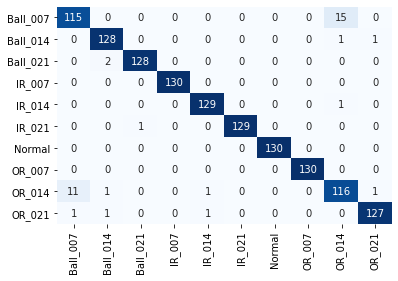

In [16]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.show()

The answers are really good, considering the fact that we have only used raw data as it is. We have done no preprocessing of the data. This approach is significantly different form the feature based approaches where we have to handcraft features beforehand before applying any machine learning algorithm. Finding those features often requires considerable domain expertise. In contrast, deep learning approaches need only data resizing (that is nothing).

[For more results on both feature based methods and deep learning methods, visit my project page.](https://biswajitsahoo1111.github.io/cbm_codes_open/)

Last modified: 13 July, 2019